In [30]:
import pandas as pd

#read file and visualise it
data = pd.read_csv('dataset.csv', nrows=1000000)

In [31]:
print(data)

        app_id          app_name  \
0           10    Counter-Strike   
1           10    Counter-Strike   
2           10    Counter-Strike   
3           10    Counter-Strike   
4           10    Counter-Strike   
...        ...               ...   
999995  214490  Alien: Isolation   
999996  214490  Alien: Isolation   
999997  214490  Alien: Isolation   
999998  214490  Alien: Isolation   
999999  214490  Alien: Isolation   

                                              review_text  review_score  \
0                                         Ruined my life.             1   
1       This will be more of a ''my experience with th...             1   
2                           This game saved my virginity.             1   
3       • Do you like original games? • Do you like ga...             1   
4                Easy to learn, hard to master.                       1   
...                                                   ...           ...   
999995  Hands down the most nerve-racking,

In [32]:
#Clean the data:
import re
#Remove duplicates, null values, and irrelevant information.
#Handle noisy data (e.g., special characters, HTML tags).
data.drop_duplicates()
#print(data['review_text'])

for review in data['review_text']:
    review = re.sub('[^A-Za-z0-9]+',' ', str(review) ).lower()



In [33]:
data['review_text'].dropna(inplace=True)

#Text preprocessing:
import nltk
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
#Tokenization, lowercasing, removing stopwords, stemming, and lemmatization.
text = data['review_text'].str.lower().astype('str')

text = text.apply(word_tokenize)
text.head()

0                                [ruined, my, life, .]
1    [this, will, be, more, of, a, ``, my, experien...
2                [this, game, saved, my, virginity, .]
3    [•, do, you, like, original, games, ?, •, do, ...
4            [easy, to, learn, ,, hard, to, master, .]
Name: review_text, dtype: object

In [34]:
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
filtered_sentences = []
for texts in text:
    filtered_sentence = []
    for word in texts:
        if word not in stop_words:
            filtered_sentence.append(word.replace('$',''))
    filtered_sentences.append(filtered_sentence)


In [35]:
#stem words
import string
#print(filtered_sentences[0])
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stemmed_sentences = []

for stentences in filtered_sentences:
    stemmed_sentence = " "
    for word in stentences:
        stemmed_sentence += " " + stemmer.stem(word)
        stemmed_sentence = stemmed_sentence.translate(str.maketrans('', '', string.punctuation))
    stemmed_sentences.append(stemmed_sentence)

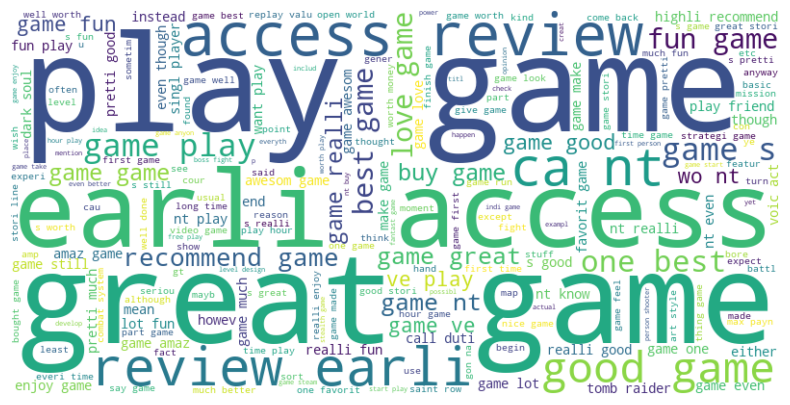

In [36]:
#print(stemmed_sentences[0])
#We already have the labels -1 = negative 1 = positive

#Now to do exploratory data analysis 
data["processed_reviews"] = stemmed_sentences

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate("+".join(data['processed_reviews'].astype('str')))

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

In [37]:
dfe = data['processed_reviews'].explode().to_frame().reset_index(drop=True)
counts = []
for review in dfe['processed_reviews']:
    string = review.split()
    for word in string:
        counts.append(word)
print(len(counts))


29671224


In [38]:
import seaborn as sns
from collections import Counter
counts = Counter(counts)
counts.most_common(10)
#honestly not as good as the word cloud IMO

[('game', 1555175),
 ('play', 458948),
 ('s', 409088),
 ('nt', 315093),
 ('like', 295687),
 ('get', 263225),
 ('fun', 226702),
 ('good', 224718),
 ('one', 221519),
 ('time', 202367)]

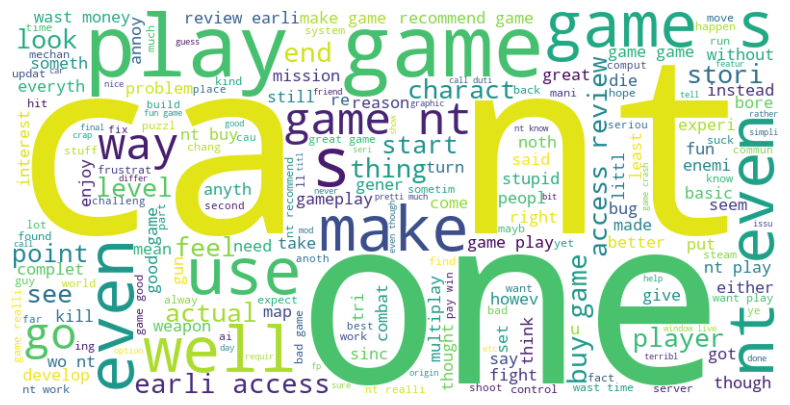

In [39]:
#all negative review word cloud
negative_data = data[data['review_score'] == -1]
# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate("+".join(negative_data['processed_reviews'].astype('str')))

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

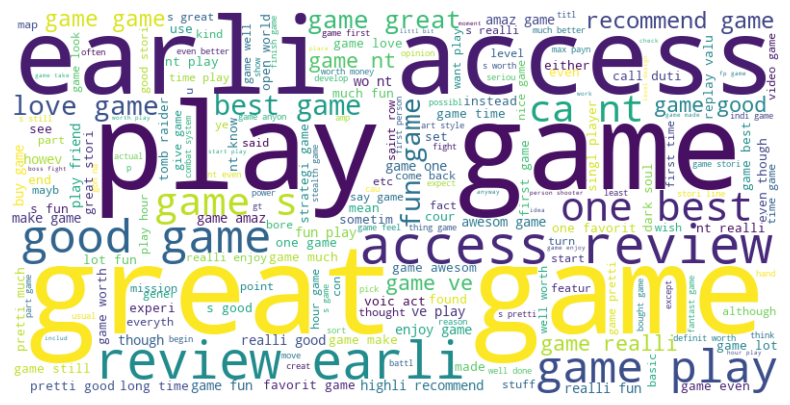

In [40]:
positive_data = data[data['review_score'] == 1]
# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate("+".join(positive_data['processed_reviews'].astype('str')))

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

In [41]:
new_processed_review = data['processed_reviews'].str.split()
data['processed_reviews'] = new_processed_review


In [42]:
import gensim

from gensim.models import Word2Vec, KeyedVectors



model = gensim.models.Word2Vec(
        data['processed_reviews'],
        window=10,
        min_count=2,
        workers=10)

In [43]:
wl = 'game'

model.wv.most_similar(wl)

[('howev', 0.6669188737869263),
 ('play', 0.585010290145874),
 ('although', 0.57825767993927),
 ('experi', 0.5624386668205261),
 ('fact', 0.5513573288917542),
 ('realli', 0.5385032296180725),
 ('one', 0.5345051288604736),
 ('gameplay', 0.5142372846603394),
 ('though', 0.5053055882453918),
 ('still', 0.49809908866882324)]

In [45]:

import numpy as np

def get_sentence_vector(sentence, model):
    #words = preprocess_text(sentence)
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no word vectors are found

sentence_vectors = [get_sentence_vector(text, model) for text in data['processed_reviews']]

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

labels = data['review_score'].tolist()
X_train, X_test, y_train, y_test = train_test_split(sentence_vectors, labels, test_size=0.2, random_state=42)
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')

C:\Users\Bobby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression Accuracy: 0.89


In [47]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Naive Bayes Accuracy: {accuracy:.2f}')

Naive Bayes Accuracy: 0.76


In [48]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,

                    hidden_layer_sizes=(5, 2), random_state=1)


clf.fit(X_train, y_train)
accuracy = accuracy_score(y_test, y_pred)
print(f'MLP Accuracy: {accuracy:.2f}')

MLP Accuracy: 0.76


C:\Users\Bobby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [49]:
import pickle

filename = 'nbmodel.sav'
pickle.dump(nb_model, open(filename,'wb'))

In [50]:
filename = 'clfmodel.sav'
pickle.dump(clf, open(filename,'wb'))

In [51]:
print(sentence_vectors[0:3])

[array([-0.30621392,  0.72665834,  0.38849312, -1.3684165 , -0.8481198 ,
       -1.4330214 ,  1.657118  ,  1.2353137 , -0.675687  , -3.272932  ,
       -0.8361019 , -1.7995802 ,  0.36026242, -1.7484    ,  1.0766289 ,
       -1.0556629 ,  0.36258662, -1.0017462 ,  2.308261  , -0.75021994,
        2.214252  ,  1.7591009 ,  1.7183393 , -0.50665736,  0.30357534,
       -0.12139875, -0.73618436,  0.59361136,  0.07723597, -0.5149678 ,
       -1.3527586 ,  2.0472913 , -1.4610517 , -0.09856451,  0.87880814,
       -1.4001937 ,  1.137955  ,  0.5214558 , -2.6644502 ,  0.26953566,
        1.5062537 ,  0.54472095,  0.5795329 , -0.6201613 , -0.1124078 ,
        0.37260512, -1.3516824 , -1.2689964 ,  2.5923066 , -1.0424145 ,
        1.1251776 ,  1.2554823 ,  1.0738547 , -0.45908868, -0.75441045,
       -0.2962882 , -1.7246294 , -2.5141797 ,  1.1717501 ,  0.54999447,
       -2.324152  ,  2.1936755 , -0.1525619 , -1.8458236 ,  2.650165  ,
       -1.4462245 , -3.3152218 ,  0.9109571 ,  1.1989951 , -1.3

In [52]:
filename = 'lrmodel.sav'
load_model = pickle.load(open(filename,'rb'))
load_model.predict([X_test[3432]])

array([1])

In [53]:
filename = 'w2v.sav'
pickle.dump(model, open(filename,'wb'))